<a href="https://colab.research.google.com/github/RiseAboveAll/RSNA_Pneumonia/blob/master/Model_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 88kB/s 


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import pydicom

import csv
import random

from glob import glob #The glob module finds all the pathnames matching a specified pattern according to the rules
import os

import tensorflow as tf
from tensorflow import keras

from skimage import measure
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split as tts

import math
import cv2

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import graphviz
import pydotplus
from keras.utils import plot_model

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.callbacks import tensorboard_v2

In [ ]:
%load_ext tensorboard


In [ ]:
#remove or clear any logs from previous runs
!rm -rf ./logs/

## Paths

In [ ]:
Path='/content/drive/My Drive/'
#Image_Path='/content/drive/My Drive/Capstone/train_images/'
os.chdir(Path)

In [ ]:
os.getcwd()

'/content/drive/My Drive'

## Read Train And Test Set

In [ ]:
train_X=pd.read_csv('/content/drive/My Drive/Train_X.csv')
val_X=pd.read_csv('/content/drive/My Drive/Val_X.csv')

## Model Parameters

In [ ]:

IMAGE_SIZE = 512 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 15 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping

MULTI_PROCESSING = False 
THREADS = 1 


## Data Sequence With Target

In [ ]:
#msk= np.zeros(img.shape)
class DataSequence(keras.utils.Sequence):

    def __init__(self, data):
        self.paths = []
        #self.mask=[]
        #self.msk= np.zeros(img.shape)
        self.coords=np.zeros((data.shape[0],5))
        for index,row in data.iterrows():
            for i,r in enumerate(row[1:5]):
                row[i+1]=int(r)
            path,xmin,xmax,ymin,ymax,Target=row
            #msk[ymin:ymax,xmin:xmax]=1
            #self.mask.append(msk)
            self.coords[index,0]=xmin/IMAGE_SIZE
            self.coords[index,1]=ymin/IMAGE_SIZE
            self.coords[index,2]=xmax/IMAGE_SIZE
            self.coords[index,3]=ymax/IMAGE_SIZE
            self.coords[index,4]=Target
            self.paths.append(path)
        

        
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE,1), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            #img = Image.open(f) # Read image
            img = pydicom.dcmread(f).pixel_array
            img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
            #img = img.convert('RGB')
            img = np.expand_dims(img, -1)

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #img.close()

        return batch_images, batch_coords
    

In [ ]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        smooth = tf.ones(tf.shape(intersections))
        #tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
        iou = tf.reduce_mean((intersections+smooth) / (unions - intersections + smooth ))
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))

In [ ]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

## Loss Function


In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred,axis=1)
    union = tf.reduce_sum(y_true,axis=1) + tf.reduce_sum(y_pred,axis=1)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


## VGG Layer Architecture



In [ ]:
import datetime

In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in
 
# define model input


## SSD Architecture

<img src="https://miro.medium.com/max/2000/1*hdSE1UCV7gA7jzfQ03EnWw.png">

<img src="https://www.researchgate.net/profile/Eric_Granger/publication/320719820/figure/fig1/AS:555253246709760@1509394098656/Single-Shot-Multi-Box-Detector-SSD-architecture.png">

## Model With Classification

In [ ]:
visible = keras.layers.Input(shape=(512,512, 1))
layer = vgg_block(visible, 32, 2)
layer = vgg_block(layer, 64, 2)
layer = vgg_block(layer, 128, 4)
layer = vgg_block(layer, 256, 4)
layer1_br = vgg_block(layer, 256, 4)#Add 1 FC layer to it 
layer2_br= Conv2D(512,(3,3),padding='same',activation='relu')(layer1_br)#Add 2nd FC layer to it 
layer3=Conv2D(512,(1,1))(layer2_br)
layer4=Conv2D(128,(1,1))(layer3)
layer4=Conv2D(256,(3,3),strides=(2,2),name='convsame',padding='same',activation='relu')(layer4)#Add 3rd FC layer to it
layer5=Conv2D(64,(1,1))(layer4)
layer5=Conv2D(128,(3,3),strides=(2,2),padding='same',activation='relu')(layer5)#Add 4rth FC layer to it
layer6=keras.layers.AveragePooling2D((3,3))(layer5)
layer7=Conv2D(4,(1,1),activation='relu')(layer6)#Add 5th FC layer to it
#layer6=Conv2D(128,(1,1))(layer5)
#layer6=Conv2D(256,(3,3))(layer6)#Add 5rth FC layer to it 

#Adding First Fully Connected Layer
flatlayer1_br=keras.layers.Flatten()(layer1_br)
flatlayer1_br= keras.layers.Dense(4,activation='relu')(flatlayer1_br)
#Adding Second Fully Connected Layer
flatlayer2_br = keras.layers.Flatten()(layer2_br)
flatlayer2_br=  keras.layers.Dense(4,activation='relu')(flatlayer2_br)

#Adding Third Fully Connected Layer
flatlayer4=keras.layers.Flatten()(layer4)
flatlayer4=keras.layers.Dense(4,activation='relu')(flatlayer4)

#Adding Fourth Fully Connected Layer
flatlayer5=keras.layers.Flatten()(layer5)
flatlayer5=keras.layers.Dense(4,activation='linear')(flatlayer5)

#Adding Fifth and Final Fully Connected Layer
flatlayer7=keras.layers.Flatten()(layer7)
flatlayer7=keras.layers.Dense(4,activation='relu')(flatlayer7)

# Adding Flat Layers

Add_Final=keras.layers.add([flatlayer1_br,flatlayer2_br,flatlayer4,flatlayer5,flatlayer7])

flatlayer8=keras.layers.Dense(4,activation="linear")(Add_Final)
clf_layer_br=keras.layers.Flatten()(layer6)
clf_layer=keras.layers.Dense(1,activation="sigmoid")(clf_layer_br)
merge_layer=keras.layers.concatenate([flatlayer8,clf_layer],axis=-1)

model = Model(inputs=visible, outputs=merge_layer)



In [ ]:
# Defining Tensorboard

log_dir="log/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callbak=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [ ]:
model.load_weights('model-h1vgg1-0.13.h5')

In [ ]:

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 512, 512, 32) 320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 512, 512, 32) 9248        conv2d_220[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_50 (MaxPooling2D) (None, 256, 256, 32) 0           conv2d_221[0][0]                 
____________________________________________________________________________________________

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=.001,nesterov=True,momentum=.9)
model.compile(loss=iou_bce_loss, optimizer=optimizer, metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.001
  epochs = 25
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

#learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-h1vgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,tensorboard_callbak],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

In [ ]:
%tensorboard --logdir logs/fit

## Classification VGG Model Architecture

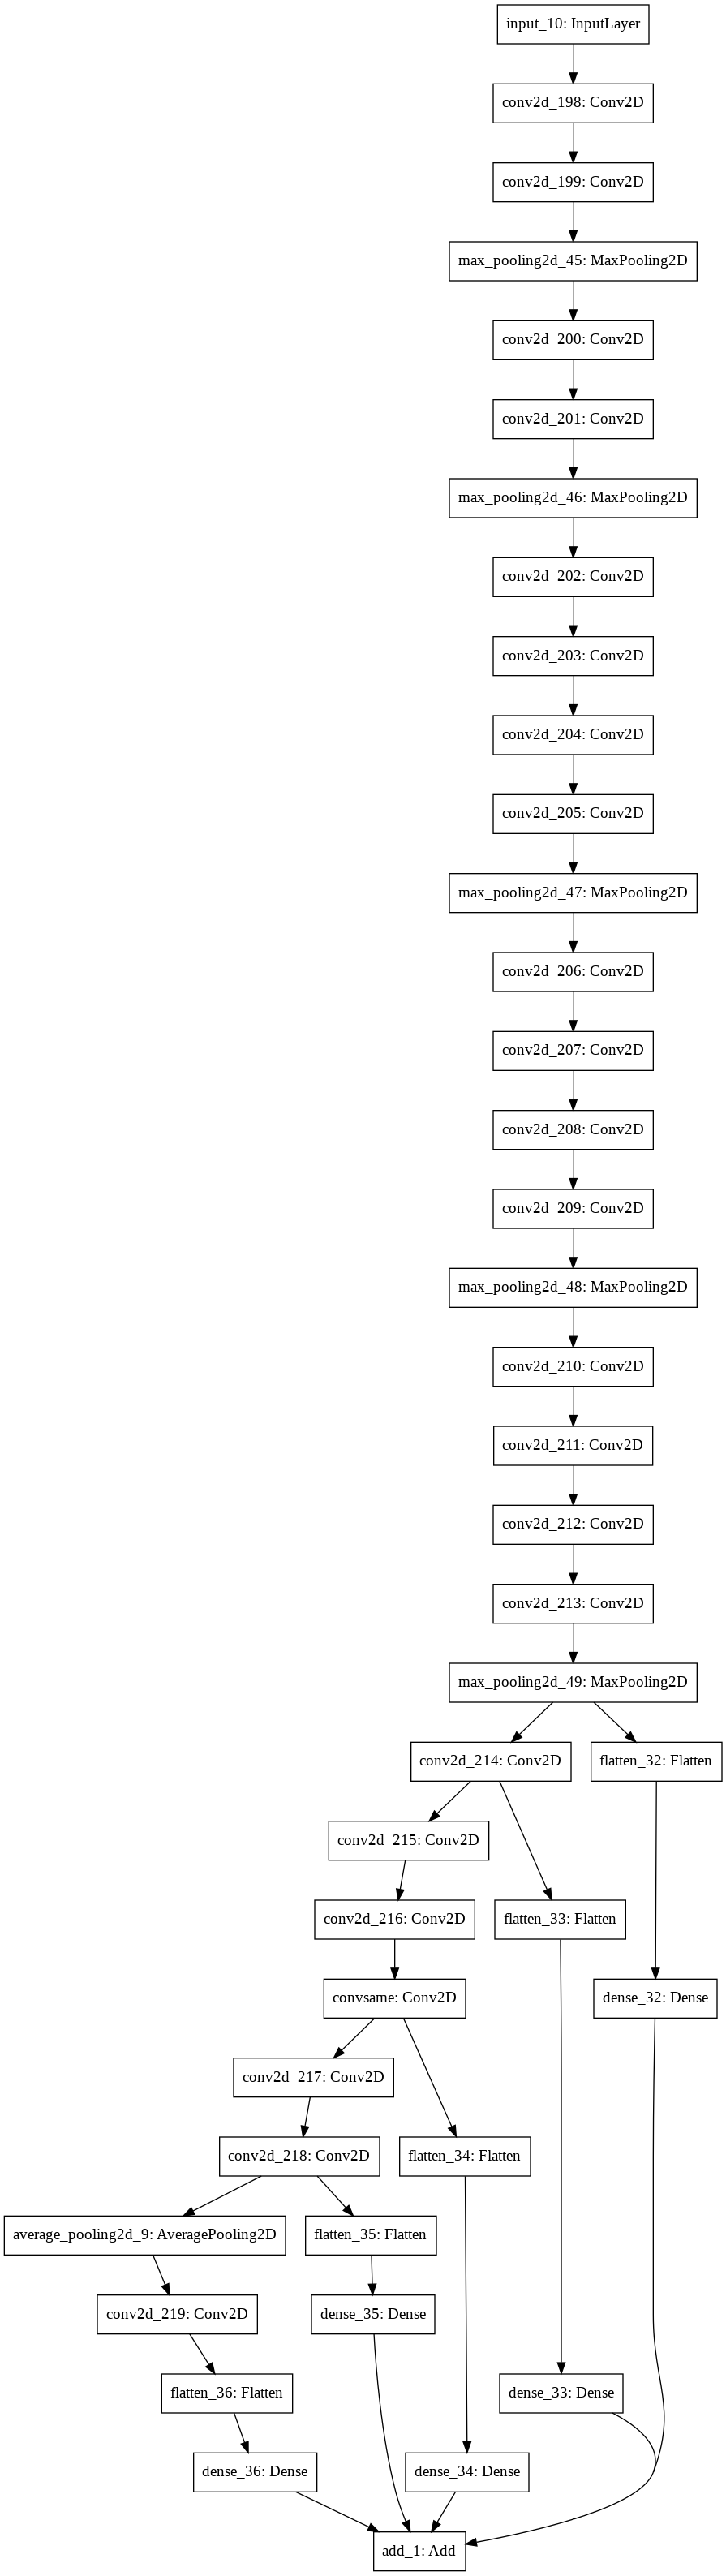

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, expand_nested=False, dpi=96
)

## Above model with Resnet- Niranjan ran

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    layer2_br= Conv2D(512,(3,3),padding='same',activation='relu')(x)
    layer3=Conv2D(512,(1,1))(layer2_br)
    layer4=Conv2D(128,(1,1))(layer3)
    layer4=Conv2D(256,(3,3),strides=(2,2),name='convsame',padding='same',activation='relu')(layer4)#Add 3rd FC layer to it
    layer5=Conv2D(64,(1,1))(layer4)
    layer5=Conv2D(128,(3,3),strides=(2,2),padding='same',activation='relu')(layer5)#Add 4rth FC layer to it
    layer6=keras.layers.AveragePooling2D((3,3))(layer5)
    layer7=Conv2D(4,(1,1),activation='relu')(layer6)#Add 5th FC layer to it
    #layer6=Conv2D(128,(1,1))(layer5)
    #layer6=Conv2D(256,(3,3))(layer6)#Add 5rth FC layer to it 

    #Adding First Fully Connected Layer
    flatlayer1_br=keras.layers.Flatten()(x)
    flatlayer1_br= keras.layers.Dense(4,activation='relu')(flatlayer1_br)
    #Adding Second Fully Connected Layer
    flatlayer2_br = keras.layers.Flatten()(layer2_br)
    flatlayer2_br=  keras.layers.Dense(4,activation='relu')(flatlayer2_br)

    #Adding Third Fully Connected Layer
    flatlayer4=keras.layers.Flatten()(layer4)
    flatlayer4=keras.layers.Dense(4,activation='relu')(flatlayer4)

    #Adding Fourth Fully Connected Layer
    flatlayer5=keras.layers.Flatten()(layer5)
    flatlayer5=keras.layers.Dense(4,activation='linear')(flatlayer5)

#Adding Fifth and Final Fully Connected Layer
    flatlayer7=keras.layers.Flatten()(layer7)
    flatlayer7=keras.layers.Dense(4,activation='relu')(flatlayer7)

# Adding Flat Layers

    Add_Final=keras.layers.add([flatlayer1_br,flatlayer2_br,flatlayer4,flatlayer5,flatlayer7])

    flatlayer8=keras.layers.Dense(4,activation="linear")(Add_Final)
    clf_layer_br=keras.layers.Flatten()(layer6)
    clf_layer=keras.layers.Dense(1,activation="sigmoid")(clf_layer_br)
    merge_layer=keras.layers.concatenate([flatlayer8,clf_layer],axis=-1)

    #model = Model(inputs=visible, outputs=merge_layer)


    model = keras.Model(inputs=inputs, outputs=merge_layer)
    return model

In [ ]:
model = create_network(input_size=512, channels=32, n_blocks=3, depth=5)


In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_357 (Conv2D)             (None, 512, 512, 32) 288         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_299 (BatchN (None, 512, 512, 32) 128         conv2d_357[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_294 (LeakyReLU)     (None, 512, 512, 32) 0           batch_normalization_299[0][0]    
___________________________________________________________________________________________

In [ ]:
# Defining Tensorboard

log_dir="log/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
%load_ext tensorboard.notebook

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=.001,nesterov=True,momentum=.9)
model.compile(loss=iou_bce_loss, optimizer=optimizer, metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.001
  epochs = 25
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

#learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-h1vgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,tensorboard],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

## Data sequence with no Target

In [ ]:
#msk= np.zeros(img.shape)
class DataSequence(keras.utils.Sequence):

    def __init__(self, data):
        self.paths = []
        #self.mask=[]
        #self.msk= np.zeros(img.shape)
        self.coords=np.zeros((data.shape[0],4))
        for index,row in data.iterrows():
            for i,r in enumerate(row[1:5]):
                row[i+1]=int(r)
            path,xmin,xmax,ymin,ymax,_=row
            #msk[ymin:ymax,xmin:xmax]=1
            #self.mask.append(msk)
            self.coords[index,0]=xmin/IMAGE_SIZE
            self.coords[index,1]=ymin/IMAGE_SIZE
            self.coords[index,2]=xmax/IMAGE_SIZE
            self.coords[index,3]=ymax/IMAGE_SIZE
            #self.coords[index,4]=Target
            self.paths.append(path)
        

        
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE,1), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            #img = Image.open(f) # Read image
            img = pydicom.dcmread(f).pixel_array
            img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
            #img = img.convert('RGB')
            img = np.expand_dims(img, -1)

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #img.close()

        return batch_images, batch_coords
    

In [ ]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))

In [ ]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

## VGG Architecture Last Layer Concatenation - Did Not use It

In [ ]:
visible = keras.layers.Input(shape=(512,512, 1))
layer = vgg_block(visible, 64, 2)
layer = vgg_block(layer, 128, 2)
layer = vgg_block(layer, 256, 4)
layer = vgg_block(layer, 512, 4)
layer1_br = vgg_block(layer, 512, 4)#Add 1 FC layer to it 
layer2_br= Conv2D(1024,(3,3),padding='same',activation='relu')(layer1_br)#Add 2nd FC layer to it 
layer3=Conv2D(1024,(1,1))(layer2_br)
layer4=Conv2D(256,(1,1))(layer3)
layer4=Conv2D(512,(3,3),strides=(2,2),name='convsame',padding='same',activation='relu')(layer4)#Add 3rd FC layer to it
layer5=Conv2D(128,(1,1))(layer4)
layer5=Conv2D(256,(3,3),strides=(2,2),padding='same',activation='relu')(layer5)#Add 4rth FC layer to it
layer6=keras.layers.AveragePooling2D((3,3))(layer5)
layer7=Conv2D(4,(1,1),activation='relu')(layer6)#Add 5th FC layer to it
#layer6=Conv2D(128,(1,1))(layer5)
#layer6=Conv2D(256,(3,3))(layer6)#Add 5rth FC layer to it 

#Adding First Fully Connected Layer
flatlayer1_br=keras.layers.Flatten()(layer1_br)
flatlayer1_br= keras.layers.Dense(4,activation='linear')(flatlayer1_br)
#Adding Second Fully Connected Layer
flatlayer2_br = keras.layers.Flatten()(layer2_br)
flatlayer2_br=  keras.layers.Dense(4,activation='linear')(flatlayer2_br)

#Adding Third Fully Connected Layer
flatlayer4=keras.layers.Flatten()(layer4)
flatlayer4=keras.layers.Dense(4,activation='linear')(flatlayer4)

#Adding Fourth Fully Connected Layer
flatlayer5=keras.layers.Flatten()(layer5)
flatlayer5=keras.layers.Dense(4,activation='linear')(flatlayer5)

#Adding Fifth and Final Fully Connected Layer
flatlayer7=keras.layers.Flatten()(layer7)
flatlayer7=keras.layers.Dense(4,activation='linear')(flatlayer7)
# Adding Flat Layers

Add_Final=keras.layers.concatenate([flatlayer1_br,flatlayer2_br,flatlayer4,flatlayer5,flatlayer7])

model_concatenate = Model(inputs=visible, outputs=Add_Final)



In [ ]:
model_concatenate.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 512, 512, 64) 640         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_242[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_55 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_243[0][0]                 
___________________________________________________________________________________________

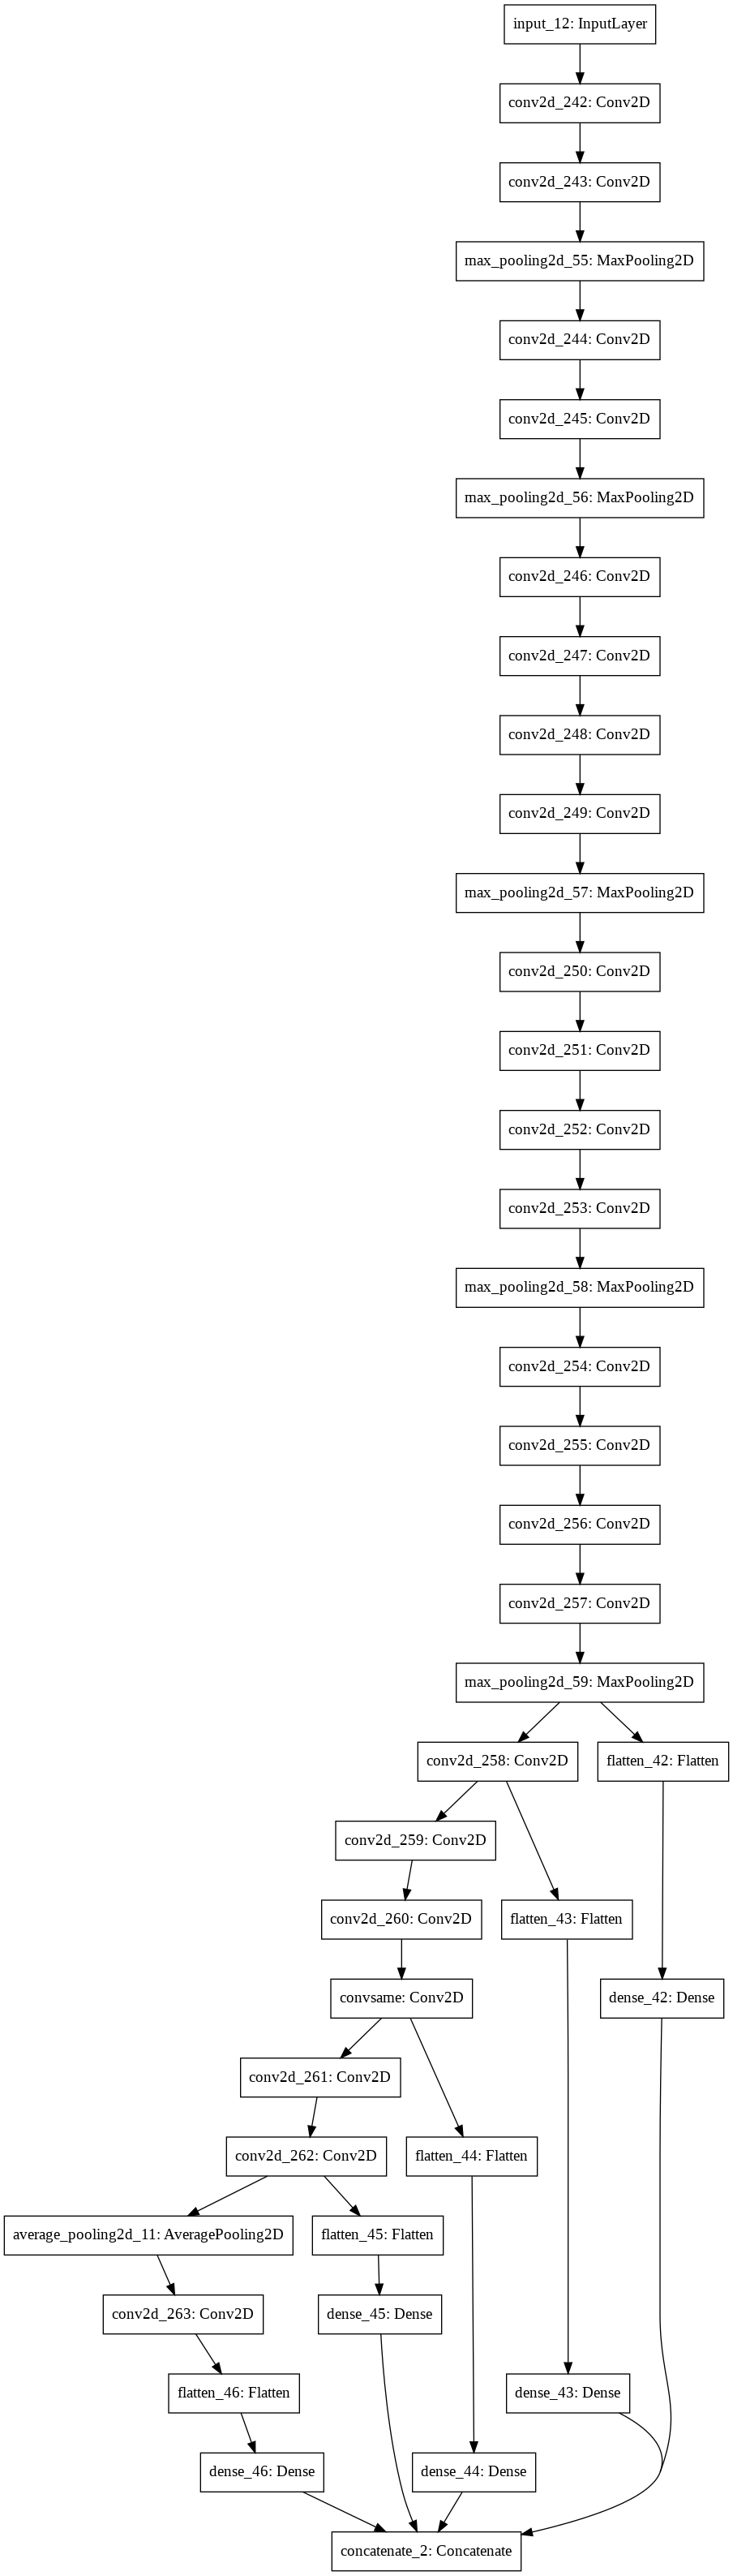

In [ ]:
tf.keras.utils.plot_model(
    model_concatenate, to_file='model.png', show_shapes=False, show_layer_names=True, expand_nested=False, dpi=96
)

## VGG Interim Architecture Tuned

In [ ]:
visible = keras.layers.Input(shape=(512, 512, 1))
# add vgg module
layer = vgg_block(visible, 16, 2)
layer = vgg_block(layer, 32, 2)
#layer=keras.layers.BatchNormalization(momentum=0.99)(layer)
layer = vgg_block(layer, 64, 2)
#layer=keras.layers.Dropout(.2)(layer)
#layer=Conv2D(6,(1,1),activation='relu')(layer)
layer = vgg_block(layer, 128, 3)
#layer=keras.layers.BatchNormalization(momentum=0.99)(layer)
layer = vgg_block(layer, 128, 3)
layer=Conv2D(64,(1,1))(layer)
layer=Conv2D(64, (3,3), padding='valid',strides=(2,2), activation='relu')(layer)
layer=Conv2D(64, (3,3), padding='same', activation='relu')(layer)
layer=Conv2D(32,(1,1))(layer)

layer=Conv2D(32, (3,3), padding='valid',strides=(2,2), activation='relu')(layer)
layer=keras.layers.MaxPooling2D((3,3),strides=(2,2))(layer)

#layer=Conv2D(4, (3,3),padding='valid', activation='relu')(layer)
#layer=Conv2D(4, (3,3),strides=(2,2), activation='relu')(layer)
layer=Conv2D(4,(1,1),activation='linear')(layer)
layer= Reshape((4,))(layer)

# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 32)      0   

In [ ]:

IMAGE_SIZE = 512 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 5 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping


MULTI_PROCESSING = False 
THREADS = 1 
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=.001,nesterov=True)
model.compile(loss=iou_bce_loss, optimizer=optimizer, metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.001
  epochs = 25
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-h1vgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=25,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,learning_rate],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/25
662/662 [==============================] - ETA: 0s - loss: 1.9681 - mean_iou: 0.5073 - val_iou: 0.1129

Epoch 00001: val_iou improved from -inf to 0.11290, saving model to model-h1vgg1-0.11.h5
662/662 [==============================] - 6157s 9s/step - loss: 1.9681 - mean_iou: 0.5073 - val_iou: 0.1129 - lr: 0.0010
Epoch 2/25
662/662 [==============================] - ETA: 0s - loss: 1.6293 - mean_iou: 0.5113 - val_iou: 0.1082

Epoch 00002: val_iou did not improve from 0.11290
662/662 [==============================] - 2168s 3s/step - loss: 1.6293 - mean_iou: 0.5113 - val_iou: 0.1082 - lr: 9.9606e-04
Epoch 3/25
662/662 [==============================] - ETA: 0s - loss: 1.6121 - mean_iou: 0.5156 - val_iou: 0.09

Epoch 00003: val_iou did not improve from 0.11290
662/662 [==============================] - 2198s 3s/step - loss: 1.6121 - mean_iou: 0.5156 - val_iou: 0.0900 - lr: 9.8429e-04
Epoch 4/25
662/662 [==============================] - ETA: 0s - loss: 1.5901 - mean_iou: 0.605

KeyboardInterrupt: ignored

In [ ]:
model.load_weights('model-hvgg1-0.14.h5')

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=.001,nesterov=True)
model.compile(loss=iou_bce_loss, optimizer=optimizer, metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.0001
  epochs = 15
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-hvgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=15,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,learning_rate],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/15
662/662 [==============================] - ETA: 0s - loss: 0.6899 - mean_iou: 0.5060 - val_iou: 0.1396

Epoch 00001: val_iou improved from -inf to 0.13960, saving model to model-hvgg1-0.14.h5
662/662 [==============================] - 1853s 3s/step - loss: 0.6899 - mean_iou: 0.5060 - val_iou: 0.1396 - lr: 1.0000e-04
Epoch 2/15
662/662 [==============================] - ETA: 0s - loss: 0.6899 - mean_iou: 0.5060 - val_iou: 0.1395

Epoch 00002: val_iou did not improve from 0.13960
662/662 [==============================] - 1853s 3s/step - loss: 0.6899 - mean_iou: 0.5060 - val_iou: 0.1395 - lr: 9.8907e-05
Epoch 3/15
 33/662 [>.............................] - ETA: 19:41 - loss: 0.6900 - mean_iou: 0.5080

KeyboardInterrupt: ignored

#Loss 

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred,axis=1)
    union = tf.reduce_sum(y_true,axis=1) + tf.reduce_sum(y_pred,axis=1)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
